# affine invariant ensemble sampler + parallel tempering

### 12D transporter model (single antiporter cycle)

10736.513516166175


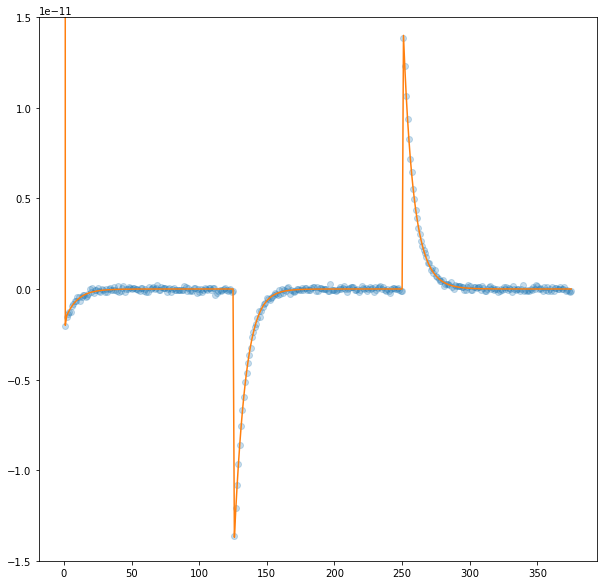

In [1]:
import numpy as np, tellurium as te, matplotlib.pyplot as plt
import emcee as mc, corner
np.random.seed(10)


# Normal log-likelihood calculation
def calc_norm_log_likelihood(mu,sigma,X):
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = len(X)
    f1 = -1*(n/2)*np.log(2*np.pi*sigma**2)
    f2_a = -1/(2*sigma**2)
    f2_b = 0 
    for i in range(n):
        f2_b += (X[i]-mu[i])**2
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
    return log_likelihood


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


antimony_string = f"""
            // Created by libAntimony v2.12.0
            model transporter_full()

            // Compartments and Species:
            compartment vol;
            species OF in vol, OF_Hb in vol;
            species IF_Hb in vol, IF_Hb_Sb in vol;
            species IF_Sb in vol, OF_Sb in vol;
            species H_in in vol, S_in in vol;
            species $H_out in vol, $S_out in vol;

            // Reactions:
            rxn1: OF + $H_out -> OF_Hb; vol*(k1_f*OF*H_out - k1_r*OF_Hb);
            rxn2: OF_Hb -> IF_Hb; vol*(k2_f*OF_Hb - k2_r*IF_Hb);
            rxn3: IF_Hb + S_in -> IF_Hb_Sb; vol*(k3_f*IF_Hb*S_in - k3_r*IF_Hb_Sb);
            rxn4: IF_Hb_Sb -> IF_Sb + H_in; vol*(k4_f*IF_Hb_Sb - k4_r*IF_Sb*H_in);
            rxn5: IF_Sb -> OF_Sb; vol*(k5_f*IF_Sb - k5_r*OF_Sb);
            rxn6: OF_Sb -> OF + $S_out; vol*(k6_f*OF_Sb - k6_r*OF*S_out);
            

            // Events:
            E1: at (time >= 5): H_out = H_out_activation, S_out = S_out_activation;
            E2: at (time >= 10): H_out = 1e-7, S_out = 0.001;

            // Species initializations:
            H_out = 1e-07;
            H_out has substance_per_volume;

            H_in = 1e-7;
            H_in has substance_per_volume;

            S_out = 0.001;
            S_out has substance_per_volume;

            S_in = 1e-3;
            S_in has substance_per_volume;

            OF = 2.833e-8;
            OF has substance_per_volume;

            OF_Hb = 2.833e-8;
            OF_Hb has substance_per_volume;

            IF_Hb = 2.833e-8;
            IF_Hb has substance_per_volume;
            
            IF_Hb_Sb = 2.833e-8;
            IF_Hb_Sb has substance_per_volume;
            
            IF_Sb = 2.125e-08;
            IF_Sb has substance_per_volume;

            OF_Sb = 2.125e-08;
            OF_Sb has substance_per_volume;


            // Compartment initializations:
            vol = 0.0001;
            vol has volume;

            // Variable initializations:
            H_out_activation = 5e-8;
            S_out_activation = 0.001;

            // Rate constant initializations:
            k1_f = 1e10;
            k1_r = 1e3;
            k2_f = 1e2;
            k2_r = 1e2;
            k3_f = 1e7;
            k3_r = 1e3;
            k4_f = 1e3;
            k4_r = 1e10;
            k5_f = 1e2;
            k5_r = 1e2;
            k6_f = 1e3;
            k6_r = 1e7;


            // Other declarations:
            const vol;
            const k1_f, k1_r, k2_f, k2_r, k3_f, k3_r;
            const k4_f, k4_r, k5_f, k5_r, k6_f, k6_r;
    

            // Unit definitions:
            unit substance_per_volume = mole / litre;
            unit volume = litre;
            unit length = metre;
            unit area = metre^2;
            unit time_unit = second;
            unit substance = mole;
            unit extent = mole;

            // Display Names:
            time_unit is "time";
            end
            """ 


m = te.loada(antimony_string)
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12

D = m.simulate(0, 15, 376, selections=['time', 'rxn4'])
y_true = D['rxn4']

noise_stdev_true = 1e-13
#y_obs = y_true + np.random.normal(0, noise_stdev_true, len(y_true))
y_obs = np.genfromtxt("data_grid_test3.csv", skip_header=1)

plt.figure(figsize=(10,10))
plt.plot(y_obs, 'o', alpha=0.25)
plt.plot(y_true)
plt.ylim(-1.5e-11, 1.5e-11)

log_like_ref = calc_norm_log_likelihood(y_true,noise_stdev_true,y_obs)

print(log_like_ref)

In [13]:
import time


def log_likelihood(theta, y_obs, extra_parameters):
    '''log of Guassian likelihood distribution'''
    sigma = 10**theta[0]
    K=theta[1:]
    m = extra_parameters[0] 
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k2_f = 10**K[2]
    m.k2_r = 10**K[3]
    m.k3_f = 10**K[4]
    m.k3_r = 10**K[5]
    m.k4_f = 10**K[6]
    m.k4_r = 10**K[7]
    m.k5_f = 10**K[8]
    m.k5_r = 10**K[9]
    m.k6_f = 10**K[10]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)

    try:
        D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
        y_tmp = D_tmp['rxn4']
        log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    except:
        log_like_tmp = -np.inf
    return log_like_tmp


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


def log_prior(theta):
    '''log of uniform prior distribution'''
    p0 = theta[0]
    p1 = theta[1]
    p2 = theta[2]
    p3 = theta[3]
    p4 = theta[4]
    p5 = theta[5]
    p6 = theta[6]
    p7 = theta[7]
    p8 = theta[8]
    p9 = theta[9]
    p10 = theta[10]
    p11 = theta[11]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if (np.log10(5e-14)<p0<np.log10(5e-13)) and (6<p1<12) and (-1<p2<5) and (-2<p3<4) and (-2<p4<4) and \
        (3<p5<9) and (-1<p6<5) and (-1<p7<5) and (6<p8<12) and (-2<p9<4) and (-2<p10<4) and (-1<p11<5):
        return 0  
    else:
        return -np.inf


def log_probability(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf  # ~zero probability
    return logp + log_likelihood(theta, y_obs, extra_parameters)  # log posterior ~ log likelihood + log prior


def set_p0():
    log_noise_sigma = np.random.uniform(np.log10(5e-14), np.log10(5e-13))
    log_k1_f = np.random.uniform(6, 12) # log10 rate constant (ref=1e10)
    log_k1_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k2_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)

    log_k3_f = np.random.uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_f = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r = np.random.uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k5_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r = np.random.uniform(-2,4)   # log10 rate constant (ref=1e2)
    log_k6_f = np.random.uniform(-1,5)  # log10  rate constant (ref=1e3)

    ## near max likelihood
#     log_noise_sigma = np.random.uniform(np.log10(0.99e-13), np.log10(1.01e-13))
#     log_k1_f = np.random.uniform(9.99, 10.01) # log10 rate constant (ref=1e10)
#     log_k1_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3)
#     log_k2_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k2_r = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k3_f = np.random.uniform(6.99, 7.01)  # log10 rate constant (ref=1e7) 
#     log_k3_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
#     log_k4_f = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
#     log_k4_r = np.random.uniform(9.99, 10.01)  # log10 rate constant (ref=1e10)
#     log_k5_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k5_r = np.random.uniform(1.99, 2.01)   # log10 rate constant (ref=1e2)
#     log_k6_f = np.random.uniform(2.99, 3.01)  # log10  rate constant (ref=1e3)
    
    p0_list_tmp = [
                log_noise_sigma ,
                log_k1_f ,
                log_k1_r ,
                log_k2_f ,
                log_k2_r ,
                log_k3_f , 
                log_k3_r ,
                log_k4_f ,
                log_k4_r ,
                log_k5_f ,
                log_k5_r ,
                log_k6_f ,
    ]
    return p0_list_tmp

seed = 12
np.random.seed(seed)

betas = np.array([1e-12, 1e-9, 1e-5, 1e-3, 0.01, 0.05, 0.15, 0.35, 0.55, 0.75, 0.85, 0.95, 0.99, 1])
n_temps = len(betas)
extra_parameters = [m]
n_steps = 10000
n_walkers = 120
n_dim = 12

p0_t_list = []
for t in range(n_temps):
    p0_t_i = []
    for i in range(n_walkers):
        p0_t_i.append(set_p0())
    p0_t_list.append(p0_t_i)
p0 = np.asarray(p0_t_list)

assert(np.shape(p0) == (n_temps,n_walkers,n_dim))

p_ref = [-13,10,3,2,2,7,3,3,10,2,2,3]
print(f"ref log likelihood: {log_likelihood(p_ref,y_obs,extra_parameters)}")
sampler = mc.PTSampler(n_temps, n_walkers, n_dim, log_likelihood, log_prior, loglargs=[y_obs, extra_parameters], betas=betas )

t_0 = time.time()
pos, lnprob, rstate = sampler.run_mcmc(p0, n_steps)
t_run = time.time() - t_0
print(f"wall clock: {t_run} s")

lp = sampler.lnprobability
print(f"{np.size(lp)} likelihood calculations")
print(f"{np.size(lp)/t_run} likelihood calculations / sec " )

ref log likelihood: 10736.513516166175


Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.90902e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.40668e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.10037e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.45994e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.42529e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.42892e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.80839e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.02724e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.24876e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.56136e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.6173e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.741e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, M

wall clock: 11048.819033145905 s
16800000 likelihood calculations
1520.5244967449319 likelihood calculations / sec 


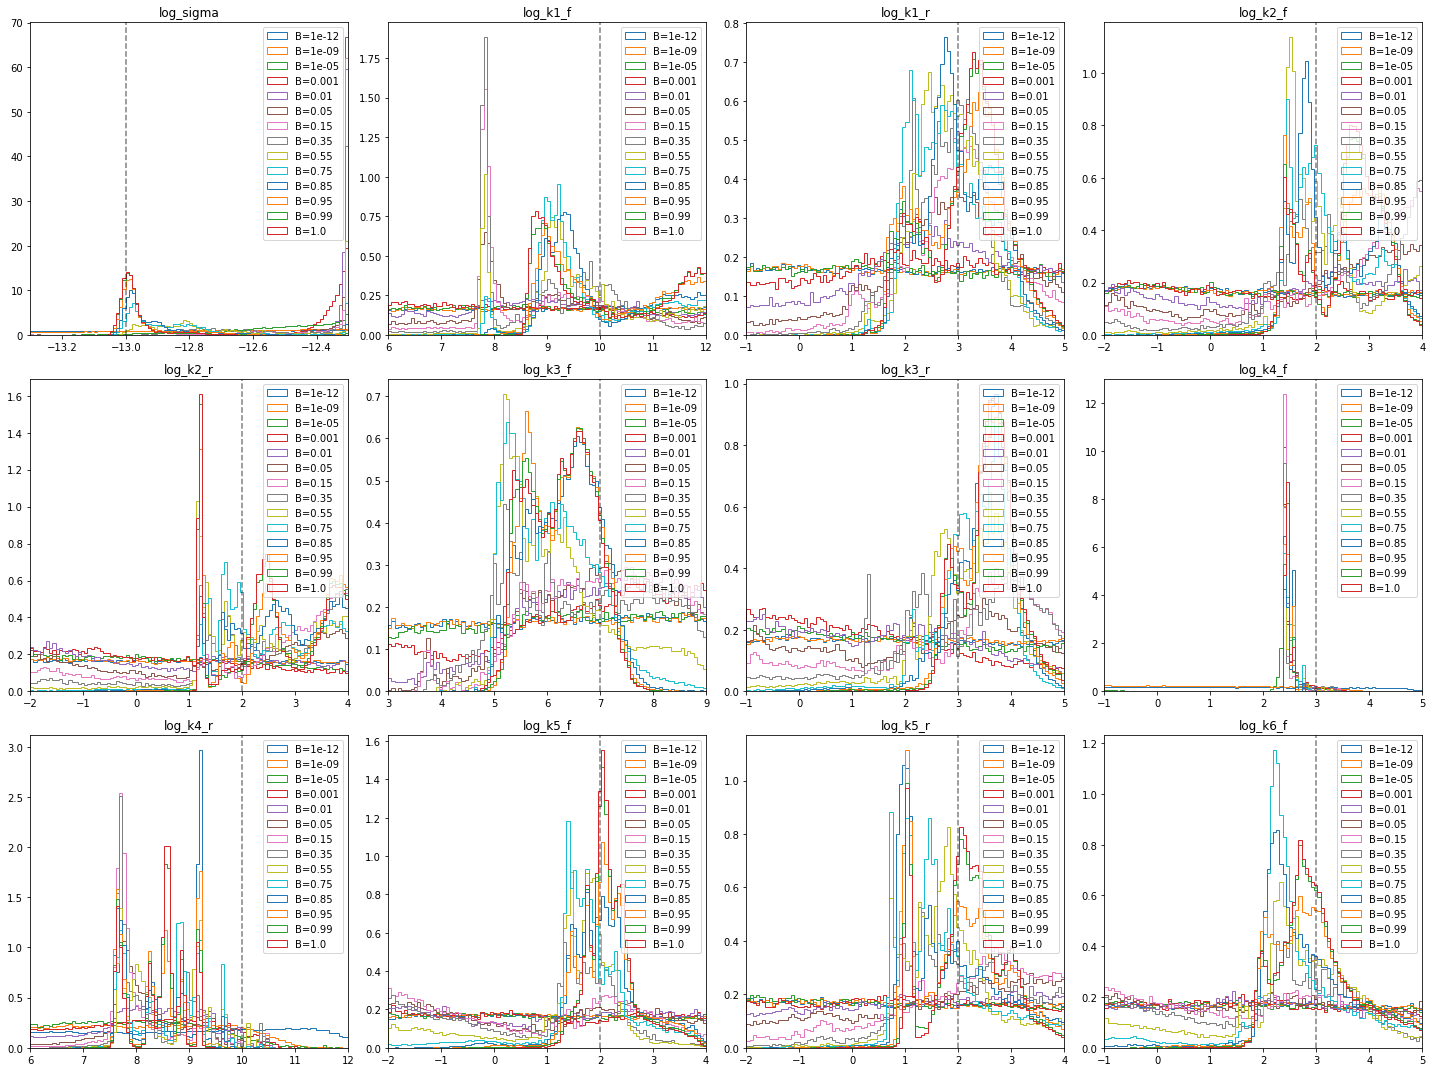

In [14]:
import corner

p_info = [
    ["log_sigma",np.log10(5e-14), np.log10(5e-13), -13],
    ["log_k1_f",6,12,10],
    ["log_k1_r",-1,5,3],
    ["log_k2_f",-2,4,2],
    ["log_k2_r",-2,4,2],
    ["log_k3_f",3,9,7],
    ["log_k3_r",-1,5,3],
    ["log_k4_f",-1,5,3],
    ["log_k4_r",6,12,10],
    ["log_k5_f",-2,4,2],
    ["log_k5_r",-2,4,2],
    ["log_k6_f",-1,5,3],
]

samples = [np.transpose(sampler.flatchain[i,:,:]) for i in range(n_temps)]
#colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple','black' ]
#colors = ['red', 'green',  'blue', 'black' ]
#assert(len(samples)==len(colors))

### 1D posterior plot
fig, ax = plt.subplots(3,4, figsize=(20,15))
axes = ax.flatten()

for i, ax_i in enumerate(axes):
    p_tmp = p_info[i]
    ax_i.set_title(f"{p_tmp[0]}")
    ax_i.axvline(p_tmp[3],ls='--', color='black', alpha=0.5)
    ax_i.set_xlim(p_tmp[1],p_tmp[2])
    
    
    for j, samples_t in enumerate(samples):
        #ax_i.hist(samples_t[i], 100, histtype="step", color=colors[j], density=True, range=(p_tmp[1],p_tmp[2]), label=f'B={betas[j]}')
        ax_i.hist(samples_t[i], 100, histtype="step", density=True, range=(p_tmp[1],p_tmp[2]), label=f'B={betas[j]}')
        ax_i.legend()
plt.tight_layout()
#plt.savefig(f'12D_transporter_AIES_PT_1D_dist_s{seed}.png')

In [ ]:
import pandas as pd
df = pd.DataFrame(np.transpose(samples[-1])[::1000], columns=[p[0] for p in p_info])
print(df)
df.to_csv(f'12D_transporter_AIES_PT_B1_samples_s{seed}.csv', sep=',')

